# CNN example from official PyTorch
- dataset: CIFAR10
- 02-05-2019 (Tue)

## Imports and Path setup

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision 
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os,sys
import pdb

In [6]:
PROJ_ROOT = Path(os.getcwd()).parent.parent
DATA_DIR = PROJ_ROOT/'data/raw'
SRC_DIR = PROJ_ROOT/'scripts'
paths2add = [PROJ_ROOT, SRC_DIR]

print("Project root: ", PROJ_ROOT)
print("Data dir: ", DATA_DIR)
print("SRC dir: ", SRC_DIR)


Project root:  /home/hayley/Playground/Spacenet_Preprocess
Data dir:  /home/hayley/Playground/Spacenet_Preprocess/data/raw
SRC dir:  /home/hayley/Playground/Spacenet_Preprocess/scripts


## Add project root and src directory to the path


In [7]:
for p in paths2add:
    p = str(p)
    if p not in sys.path:
        sys.path.insert(0, p)
        print("Prepened to path: ", p)
        

Prepened to path:  /home/hayley/Playground/Spacenet_Preprocess
Prepened to path:  /home/hayley/Playground/Spacenet_Preprocess/scripts


---

## Datasets and Dataloaders

torchvision.transforms take in PIL Image instances and perform specific image processings.

In [8]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),
                              (0.5,0.5,0.5))
        ])
trainset = torchvision.datasets.CIFAR10(root=str(DATA_DIR), 
                                        train=True, download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=str(DATA_DIR),
                                       train=False, download=True,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)
CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


---
## Visualization helpers

In [9]:
def to_npimg(t):
    """
    Returns a new view of tensor t (nc, h, w) as a numpy array of (h,w,nc)
    Note: this is an operation which assumes the input is image data with (h,w,nc).
        - if t is 3-dim, we assume t's dimensions represent (n_channels, h, w) and 
        *not* (num_grayscale_images, h, w)
        - if t has 4 dims, we assume t's dimensions correspond to (batch_size, n_channels, h, w)
    These assumptions matter because tensor and numpy images use different conventions in 
    interpreting each dimension: 
        - tensor: (nc, h, w) or (n_batchs, nc, h, w)
        - numpy_imgarray : (h,w,nc) or (n_batches, h, w, nc)
    n_channels (`nc`) is equivalent to `num_planes` in PyTorch documentation.
    """
    #todo: handle 1dim and 2dim 
    if t.dim() not in [3, 4]:
        raise TypeError("input must have dim of 3 or 4: {}".
                        format(t.dim()))
                        
    if t.dim() == 3:
        return t.permute(1,2,0).numpy()
    else:
        return np.array(list(map(to_npimg, t)))
def test_to_npimg_3dim():
    print("testing 3dim tensor: ")
    t = torch.ones(3,5,5)
    t[0:2,:,:] = 0
    npimg = to_npimg(t)
    print(npimg.shape)
    for i in range(3):
        print(npimg[:,:,i].sum())
def test_to_npimg_4dim():
    print("Testing 4dim tensor: ")
    t = torch.ones(2,3,5,5)
    t[:,0:2,:,:] = 0
    npimg = to_npimg(t)
    print(npimg.shape)
    for n in range(2):
        print("{}th tensor...".format(n))
        for i in range(3):
            print(npimg[n,:,:,i].sum())
            

In [10]:
# test_to_npimg_3dim()
test_to_npimg_4dim()

Testing 4dim tensor: 
(2, 5, 5, 3)
0th tensor...
0.0
0.0
25.0
1th tensor...
0.0
0.0
25.0


In [11]:
def batch_y2str(batch_y, delim=", "):
    batch_str = [CLASSES[l.item()] for l in batch_y]
    return delim.join(list(map(str, batch_str)))
        
def show_tensor(img_t, figsize=(10,10), title=""):
    """
    Show an 3dim image tensor (nc, h, w)
    """
    # unnormalize
    img_t = img_t/2 + 0.5
    img_np = to_npimg(img_t)
    f,ax = plt.subplots(figsize=figsize)
    ax.imshow(img_np)
    ax.set_title(title)
    f.show()
    return f, ax
def show_batch(dataloader):
    """
    Show the first mini-batch opf images from the dataloader
    Args:
    - dataloader (iterable)
    
    """
    batch_X, batch_y = iter(dataloader).next()
    grid = torchvision.utils.make_grid(batch_X)
    title = batch_y2str(batch_y)
    show_tensor(grid, figsize=(20,20), title=title)
    

/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


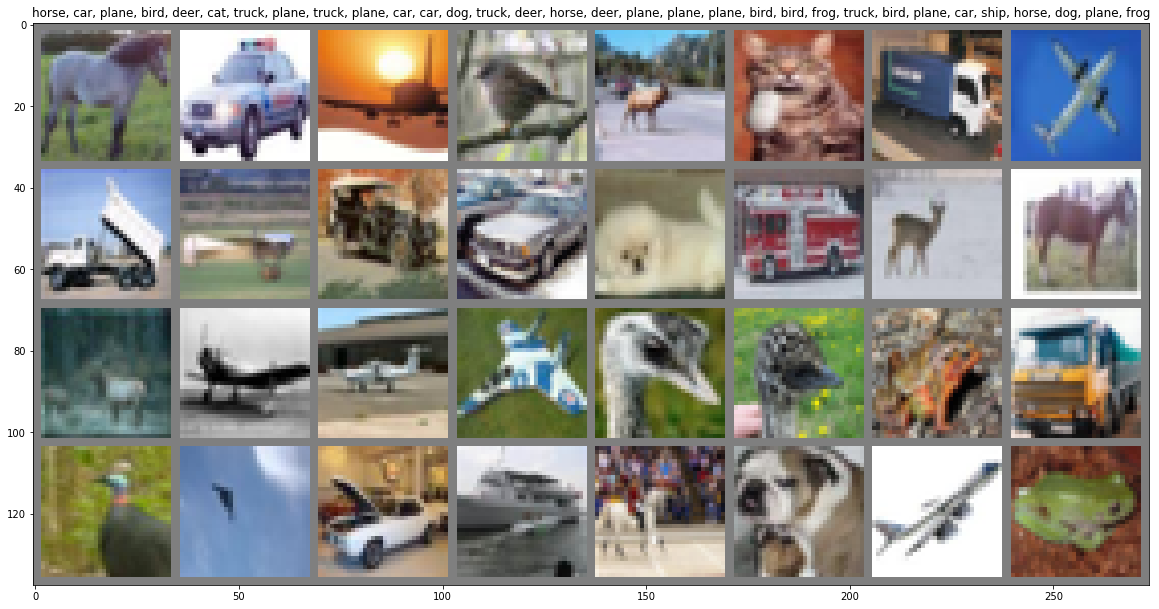

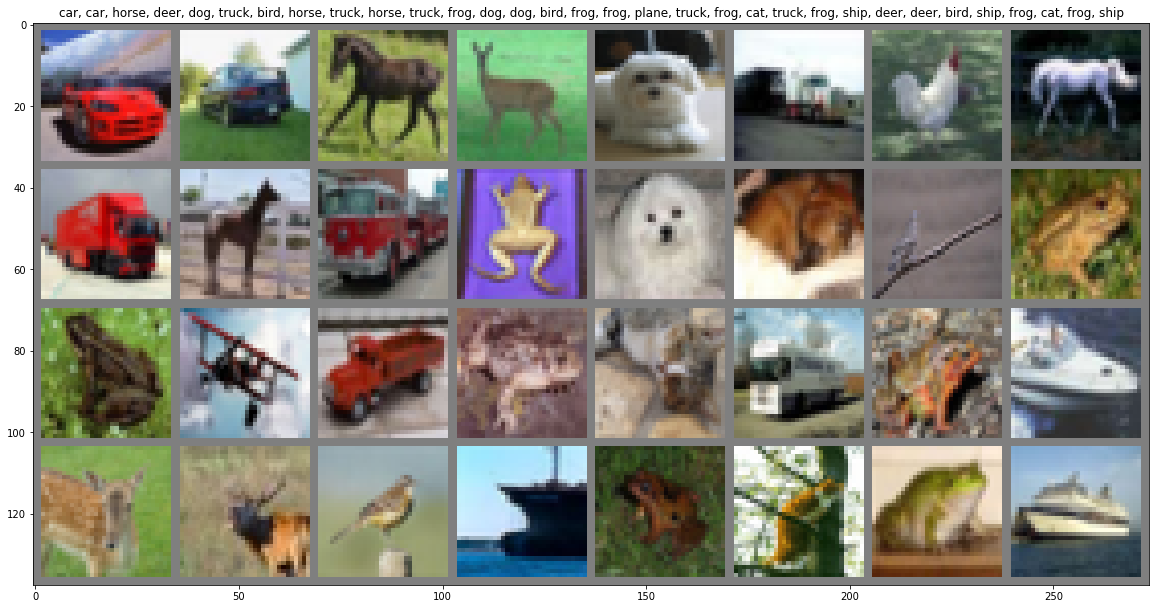

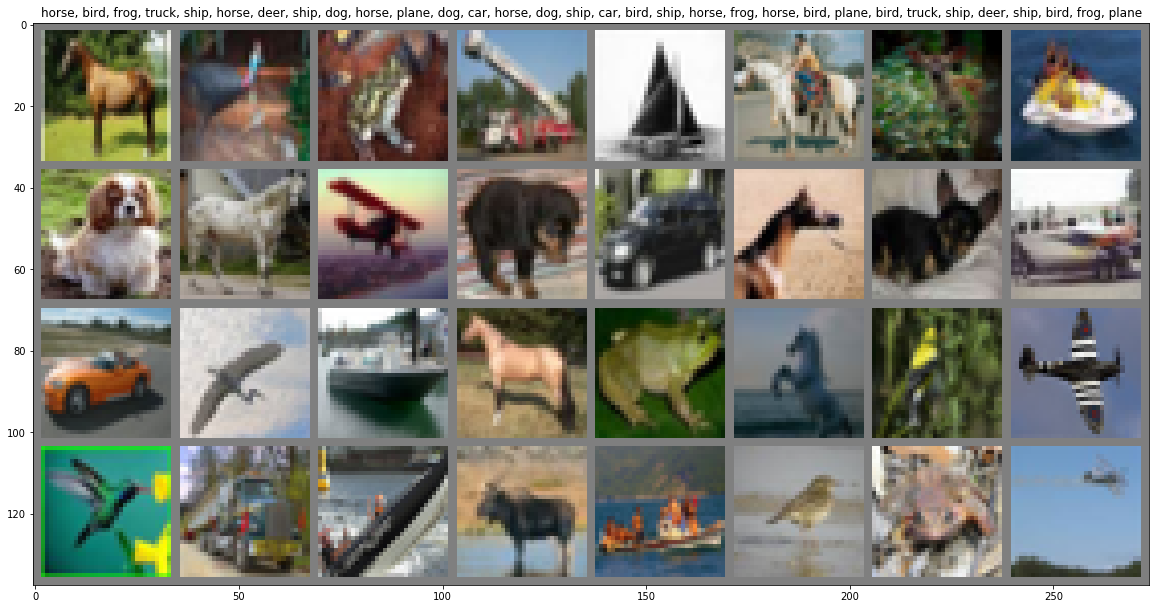

In [12]:
def test_show_tensor():
    for i in range(3):
        batch_X, batch_y = iter(trainloader).next()
        grid = torchvision.utils.make_grid(batch_X)
        title = batch_y2str(batch_y)
        show_tensor(grid, figsize=(20,20), title=title)
test_show_tensor()

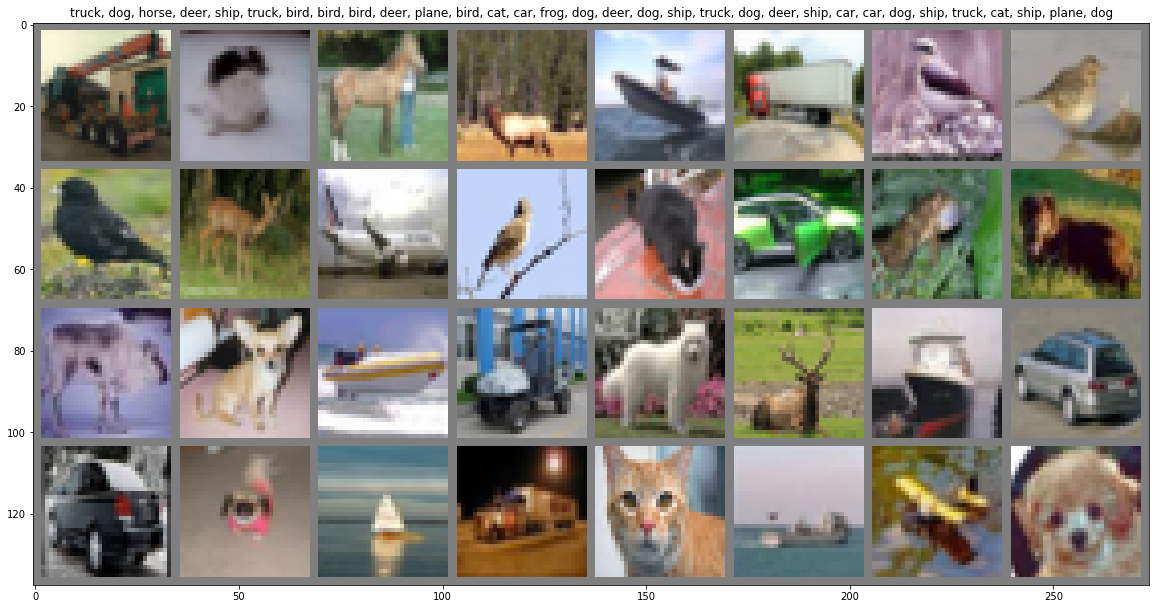

In [14]:
def test_show_batch():
    show_batch(trainloader)
test_show_batch()

In [223]:
def show_samples(n, dataloader, figsize=(20,20)):
    """
    Show n batch of X data from the dataloader.
    Assumes:
    - batch_x is a mini-batch of 3dim image tensor,
    - batch_y is a mini-batch of class labels
    
    """
    it = iter(dataloader)
    assert( n <= len(dataloader) )
    for i in range(n):
        batch_x, batch_y = it.next()
        labels_str = batch_y2str(batch_y)
        grid = torchvision.utils.make_grid(batch_x)
        show_tensor(grid, 
                    figsize=figsize, 
                    title=labels_str)
        
def show_train_samples(n=10):
    nprint("Train sample batches")
    show_samples(n, trainloader)
def show_test_samples(n=10):
    nprint("Test sample batches")
    show_samples(n, testloader)

Train sample batches


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f0259c25cf8>>
Traceback (most recent call last):
  File "/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/hayley/miniconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/hayley/miniconda3/envs/fastai/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/hayley/minic

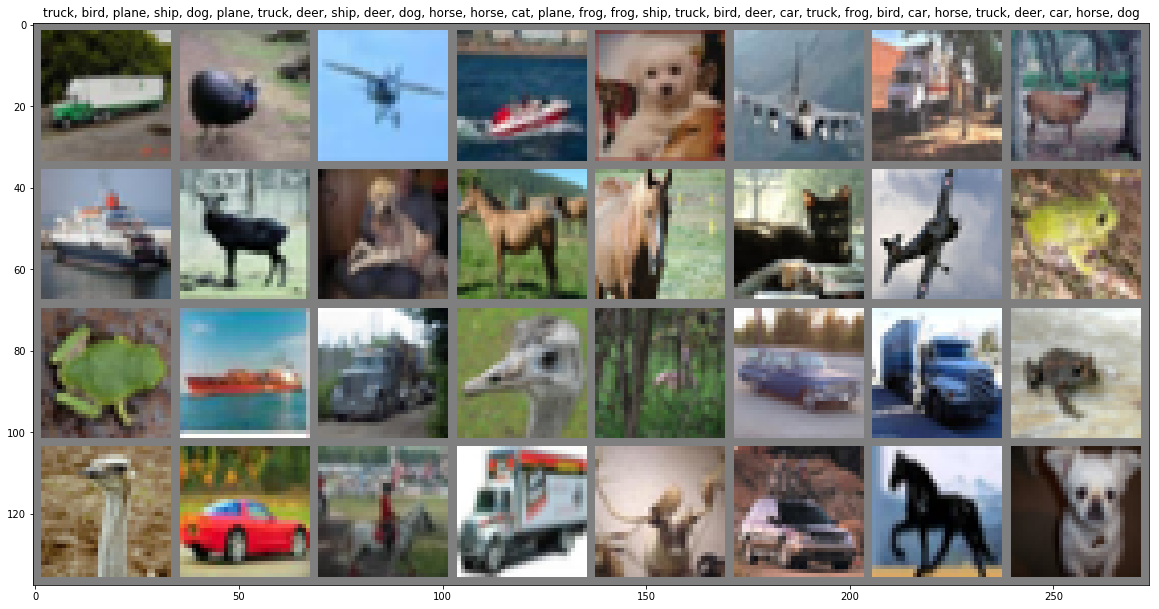

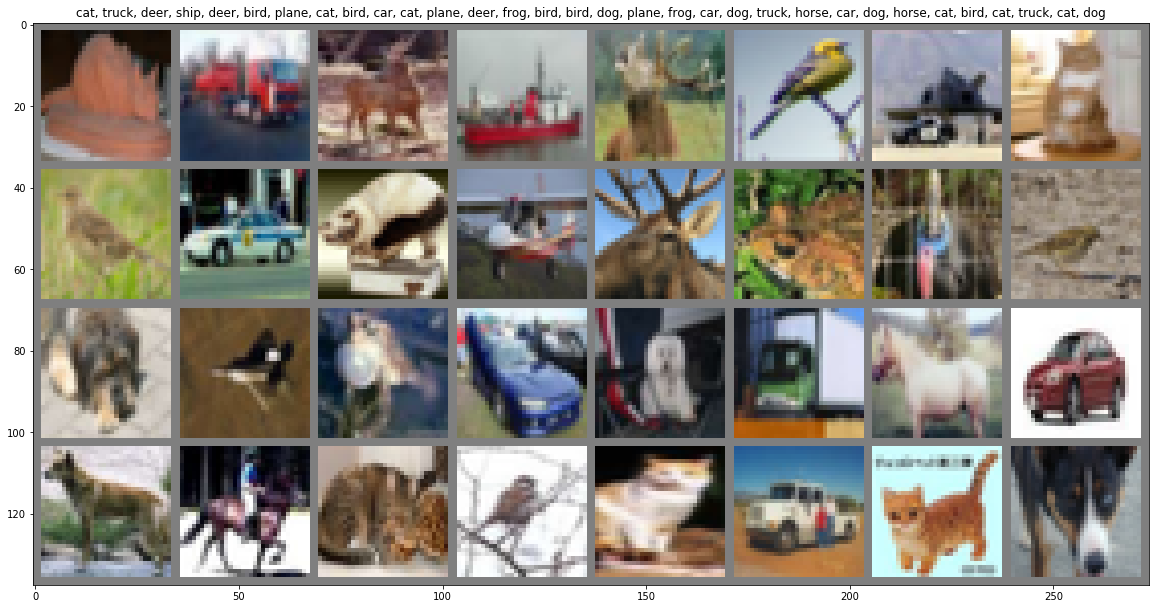

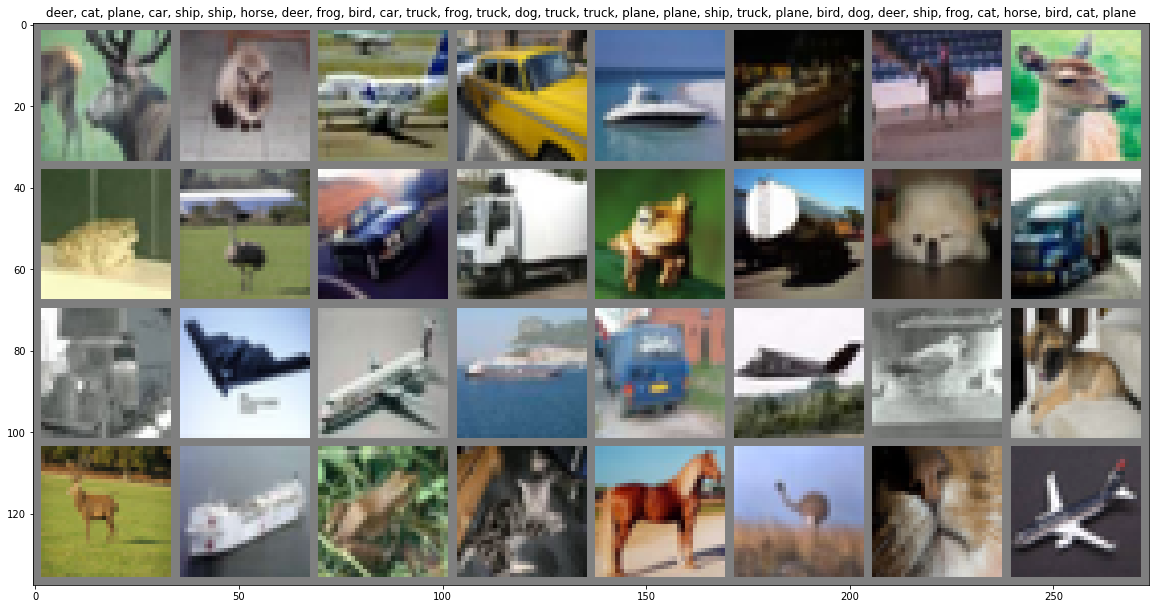

In [224]:
show_train_samples(n=3)

Test sample batches


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f0261eed6d8>>
Traceback (most recent call last):
  File "/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/hayley/miniconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/hayley/miniconda3/envs/fastai/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/hayley/miniconda3/envs/fastai/lib

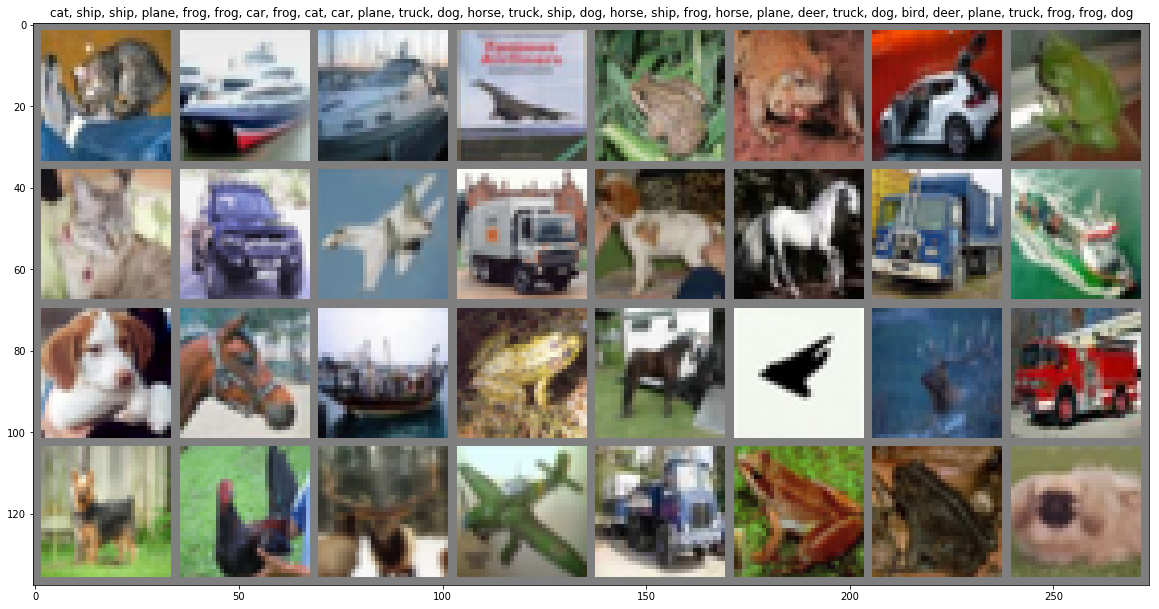

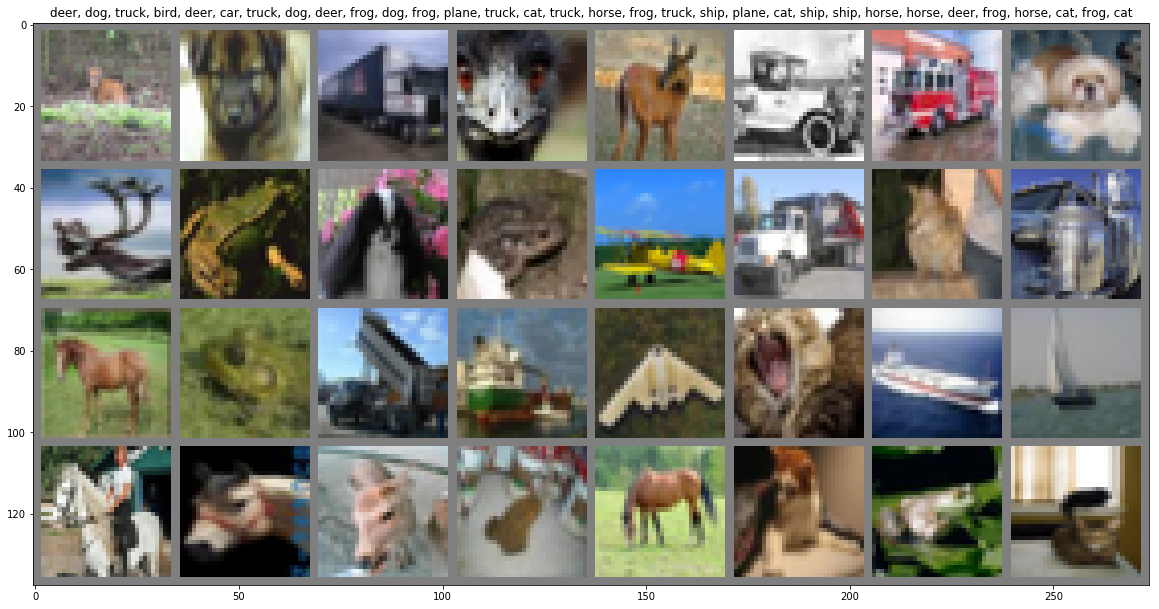

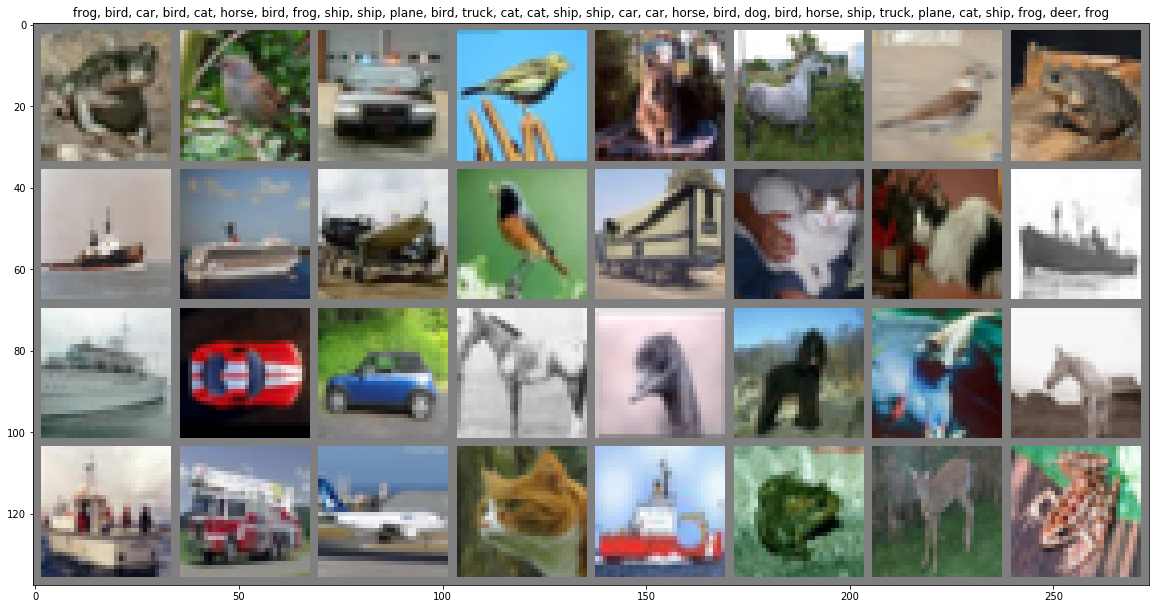

In [225]:
show_test_samples(n=3)
    

In [49]:
# Define a CNN layer
def get_convolved_size(x, f, pad, stride):
    """
    Given an input of (x,x) image, return the output spatial dimension
    after convolving with a filter of size f and pad and stride as specified
    Args:
    - x (int): input size
    - f (int): size of the convolution filter
    - pad (int): padsize (which is added at four sides)
    - stride (int): number of steps to slide the convolution filter spatially
    
    Returns:
    - (int): output image's size
    """
    return np.floor((x + 2*pad - f)/stride) + 1

def test_get_convolved_size():
    x = 10
    print(get_convolved_size(x, 3,1,1))

def test_get_convolved_size_2():
    x = 11
    print(get_convolved_size(x, 3,1,1))
test_get_convolved_size()
test_get_convolved_size_2()
          
    

10.0
11.0


In [53]:
def get_pooled_size(x, f, stride):
    """
    Given an input of (x,x) image, return the output spatial dimension
    after max-pooling with a filter of size f and stride as specified
    
    Args:
    - x (int): input size
    - f (int): max-pool window size
    - stride (int): number of steps to slide the pooling window spatially
    
    Returns:
    - (int): output image's size after max-pooling
    """
    return np.floor((x-f)/stride) + 1

def test_get_pooled_size_1():
    x = 10
    f = 2
    stride = 2
    print("x: {}, f:{}, s: {}".
          format(x, f, stride))
    print("after: ", get_pooled_size(x,f,stride))

test_get_pooled_size_1()

x: 10, f:2, s: 2
after:  5.0


In [74]:
# class MyCNN(nn.Module):
#     def __init__(self, in_shape, out_channels, n_filters, f_sizes, p_sizes, n_hs):
#         """
#         Assumes an input tensor of 4 dim (batch_size, nc, h, w)
#         Architecture:
#         - conv2d - maxpool2x2 - relu - fc
#         """
#         super(MyCNN, self).__init__()
#         _, self.in_channels, self.in_h, self.in_w = in_shape
#         self.n_filters = n_filters # a list of number of filters for each conv layer
#         self.f_sizes = f_sizes # a list of kernel sizes
#         self.p_sizes = p_sizes # a list of paddings for convolution layers
#         self.n_hs = n_hs# a list of hidden units for fc layers
#         self.out_channels = out_channels
        
#         # layers
#         self.conv1 = nn.Conv2d(in_channels, n_filters[0], f_sizes[0])
#         self.h, self.w = get_convolved_size(in_h, f_sizes[0], 
#         self.pool = nn.MaxPool2d(2,2)
# #         self.conv2 = nn.Conv2d(n_filters[0], n_filters[2], f_sizes[1])
        
#         # todo: compute spatial size (ie. h,w) after conv1-pool-conv2-pool
#         self.last_h, self.last_w = self._compute_spatial_dim(self.n_filters, f_sizes, p_sizes)
#         self.fc1 = nn.Linear(n_filters[1]*self.last_h*self.last_w, n_hs[0])
#         self.fc2 = nn.Linear(n_hs[0], n_hs[1])
#         self.fc3 = nn.Linear(n_hs[1], out_channels) # 10 for number of labels
        
#     def _compute_spatial_dim(self):
#         """Compute the size of the hidden volumn after the convolution and pooling 
#         Assume n_filters,f_sizes, and p_sizes have same length
#         """
#         assert( len(n_filters) == len(f_sizes) == len(p_sizes))
        
#         return 
#     def forward(self,x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, x.numel()) # better way to flattened x?
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
# myCNN = MyCNN()

In [83]:
def Conv3x3(in_channels, out_channels, stride=1):
    """
    Use it like this:
    conv3x3 = Conv3x3(3, 3) # Creates three filters each of which operates on a 3-channel image
    batch_x, batch_y = iter(trainloader).next()
    convolved_x = conv3x3(batch_x)
    """
    return nn.Conv2d(in_channels, out_channels, 
                         kernel_size=3, 
                         stride=stride, 
                         padding=1,
                         bias=False) # don't need bias terms if it's followed by BN layer



In [80]:
class MyCNN(nn.Module):
    def __init__(self, in_shape, out_channels, n_filters, f_sizes, p_sizes, n_hs):
        """
        Assumes an input tensor of 4 dim (batch_size, nc, h, w)
        Architecture:
        - conv2d - maxpool2x2 - relu - fc
        """
        super(MyCNN, self).__init__()
        _, self.in_channels, self.in_h, self.in_w = in_shape
        self.n_filters = n_filters # a list of number of filters for each conv layer
        self.f_sizes = f_sizes # a list of kernel sizes
        self.p_sizes = p_sizes # a list of paddings for convolution layers
        self.n_hs = n_hs# a list of hidden units for fc layers
        self.out_channels = out_channels
        
        # layers self.conv3x3 = nn.Conv2d(in_channels, n_filters, f, )
        self.h, self.w = get_convolved_size(in_h, f_sizes[0], 
        self.pool = nn.MaxPool2d(2,2)
#         self.conv2 = nn.Conv2d(n_filters[0], n_filters[2], f_sizes[1])
        
        # todo: compute spatial size (ie. h,w) after conv1-pool-conv2-pool
        self.last_h, self.last_w = self._compute_spatial_dim(self.n_filters, f_sizes, p_sizes)
        self.fc1 = nn.Linear(n_filters[1]*self.last_h*self.last_w, n_hs[0])
        self.fc2 = nn.Linear(n_hs[0], n_hs[1])
        self.fc3 = nn.Linear(n_hs[1], out_channels) # 10 for number of labels
        
    def _compute_spatial_dim(self):
        """Compute the size of the hidden volumn after the convolution and pooling 
        Assume n_filters,f_sizes, and p_sizes have same length
        """
        assert( len(n_filters) == len(f_sizes) == len(p_sizes))
        
        return 
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, x.numel()) # better way to flattened x?
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
myCNN = MyCNN()

SyntaxError: invalid syntax (<ipython-input-80-173b28d2fa1d>, line 22)

In [145]:
class HayleyNet(nn.Module):
    def __init__(self, in_channels, n_filters, out_channels):
        """
        Assumes input image of size (32, 32) and the MaxPooling of 2x2 window 
        with stride 2.  As a result of max-pool, the input will be halved in (h,w).
        
        Args:
        - in_channels: number of channels in the mini-batch of images
        - n_filters: number of filters in the convolution layer
        - out_channels: number of target classes
        """
        super(HayleyNet, self).__init__() # in Python3: super().__init__()
        self.in_channels = in_channels
        self.n_filters = n_filters
        self.out_channels = out_channels
        
        self.conv = Conv3x3(in_channels,  n_filters)
        self.pool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU(inplace=True)
        
        # Assume input size is 32x32 and the MaxPool downsamples by half
        # Therefore, 16 is the input width and height now.
        self.fc1 = nn.Linear(n_filters * 16 * 16, out_channels, bias=True)
    
    def forward(self, x):
        x = self.pool(self.conv(x))
        x = self.relu(x)
        
        # flatten x for the following fully-connected layer
        x = x.view(x.size(0), -1)
#         print("x size: ", x.size())
#         pdb.set_trace()
        x = self.fc1(x)
        return x


In [151]:
# Device config
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device: ", device)

device:  cuda:0


In [156]:
# Hyperparams
n_epochs = 10
n_classes = 10
batch_size = 70
lr = 0.001

in_channels = 3 # CIFAR10 images are in RGB domain
n_filters = 10 # hyperparam
out_channels = 10 # CIFAR10 has 10 target labels

# Model
model = HayleyNet(in_channels, n_filters, out_channels)
# device = 'pu' # todo: just for now..
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss() #takes in a batch of score vectors for each class as the first argument,
# and a batch of correct label (int)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [157]:
model

HayleyNet(
  (conv): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace)
  (fc1): Linear(in_features=2560, out_features=10, bias=True)
)

In [158]:
def check_device(model):
    from collections import Counter
    counter = Counter()
    for param in model.parameters():
        counter[str(param.device)] += 1
    return counter
def test_check_device():
    nprint(model)
    print(check_device(model))
test_check_device()

HayleyNet(
  (conv): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace)
  (fc1): Linear(in_features=2560, out_features=10, bias=True)
)
Counter({'cuda:0': 3})


In [ ]:
# train
n_iters = len(trainloader)
for epoch in range(n_epochs):
    for i, (batch_x, batch_y) in enumerate(trainloader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
       
        # forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backprop and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1000 ==0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, n_epochs, i, n_iters+1, loss.item()))
        
    # todo: evaluation at the end of each epoch
    # todo: save the model
    # todo: logging to tensorboard
    torch.save(model.state_dict(), './model_{}.pth'.format(epoch))
    
    
# test
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (test_x, test_y) in enumerate(testloader):
        test_x, test_y = test_x.to(device), test_y.to(device)
        outputs = model(test_x)
        _, preds = torch.max(outputs.data, 1 ) #todo: why .data?
        
        correct += (preds == test_y).sum().item()
        total += len(preds) #or, preds.size(0)
    print("Test accuracy on {} images: {}".
          format(total, correct/total))

        
         

### 02-10-2019 (Sun)
todo:
- [ ] add progress bar
- [x] debug input size error
- [ ] make the road dataset into a separate script 
- [ ] define the road train,val,test dataset and create dataloaders
- [ ] use hayleynet?
        

---

## Play with nn.MaxPool2d()

torch.Size([4, 3, 32, 32]) torch.Size([4])


/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


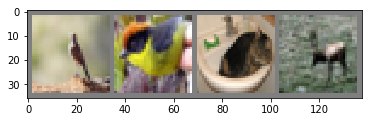

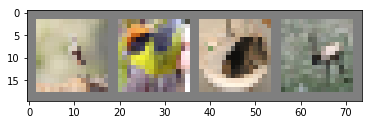

In [72]:
def demo_maxPool2x2(dataloader):
    pool = nn.MaxPool2d(2,stride=2)
    X_batch, y_batch =  iter(dataloader).next()
    print(X_batch.size(), y_batch.size())
    X_pooled = pool(X_batch)

    grid = torchvision.utils.make_grid(X_batch)
    grid2 = torchvision.utils.make_grid(X_pooled)

    show_tensor(grid)
    show_tensor(grid2)
demo_maxPool2x2(trainloader)

torch.Size([4, 3, 32, 32]) torch.Size([4])


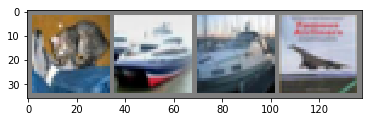

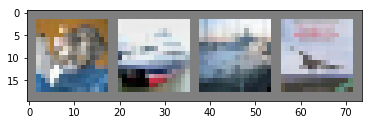

In [73]:
demo_maxPool2x2(testloader)

In [116]:
x, y = iter(trainloader).next()


In [118]:
y.size()

torch.Size([4])